In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import itertools as it

In [2]:
training_data = np.loadtxt('../../NNQuST-master/benchmarks/c++/training_data.txt').astype(np.float32)
target_psi = np.loadtxt('../../NNQuST-master/benchmarks/c++/target_psi.txt').astype(np.float32)
target_psi = tf.reshape(target_psi, shape = [1024, 1])

In [94]:
class RBM:
    
    def __init__(self, train_data_file, num_hidden, num_visible, learning_rate, momentum, batch_size, weights=None, visible_bias=None, hidden_bias=None):
        
        # number of hidden units and visible units
        self.train_data_file = train_data_file
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size # mini batch size for Stoch. grad. desc.
        self.momentum = momentum   
        
        # initialize weights, visible bias and hidden bias
        self.weights = tf.Variable(tf.random_normal(shape=(self.num_visible, self.num_hidden), mean = 0.0, 
                                                    stddev = 0.1, dtype = tf.float32, seed = None, name = None), tf.float32
                                  name = 'weights') # rows = num_hid, cols = num_vis
        
        #self.weights = tf.get_variable('weights', shape = (self.num_visible, self.num_hidden), initializer = tf.random_normal_initializer)
        
        self.hidden_bias = tf.Variable(tf.zeros(shape=(self.num_hidden,1)), tf.float32, name = 'hidden biases')
        self.visible_bias = tf.Variable(tf.zeros(shape=(self.num_visible,1)), tf.float32, name = 'visible biases')
        
        # velocities for momentum
        #self.weights_vel = tf.Variable(tf.zeros_like(self.weights), dtype = tf.float32)
        #self.visible_bias_vel = tf.Variable(tf.zeros_like(self.visible_bias), dtype = tf.float32)
        #self.hidden_bias_vel = tf.Variable(tf.zeros_like(self.hidden_bias), dtype = tf.float32)
        
        self._all_hidden_states = None
        self.max_feasible_for_log_pf = 24
        
    @property
    def all_hidden_states(self):
        if self._all_hidden_states is None:
            assert self.num_hidden <= self.max_feasible_for_log_pf, \
                'cannot generate all hidden states for num_hidden > {}'.format(self.max_feasible_for_log_pf)
            self._all_hidden_states = np.array(list(it.product([0, 1], repeat=self.num_hidden)), dtype=np.float32)
        return self._all_hidden_states
    
    # log of partition function - all visibles
    def exact_logZ(self,visible_space):
        free_energy_ = self.free_energy(visible_space)
        logZ = tf.reduce_logsumexp(free_energy_)
        return logZ

    # partition function - all visibles
    def exact_Z(self):
        return tf.exp(self.exact_logZ) # this is Z

    # calculate NLL
    def negative_log_likelihood(self, visible_samples, log_Z):
        free_energy  = tf.matmul(visible_samples, self.visible_bias)
        free_energy += tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) 
                                                    + tf.transpose(self.hidden_bias)),1)
        
        return -tf.reduce_mean(free_energy - log_Z)      

    # juan's code for exact logZ
    def exact_log_partition_function(self):
        with tf.name_scope('exact_log_Z'):
            # Define the exponent: H*b + sum(softplus(1 + exp(a + w*H.T)))
            first_term = tf.matmul(self.all_hidden_states, self.hidden_bias, name='first_term')
            with tf.name_scope('second_term'):
                second_term = tf.matmul(self.weights, self.all_hidden_states, transpose_b=True)
                second_term = tf.nn.softplus(tf.add(self.visible_bias, second_term))
                second_term = tf.transpose(tf.reduce_sum(second_term, reduction_indices=[0], keep_dims=True))
            exponent = tf.cast(first_term + second_term, dtype=tf.float64, name='exponent')
            #exponent_mean = tf.reduce_mean(exponent)
            exponent_mean = tf.reduce_max(exponent)

            return tf.log(tf.reduce_sum(tf.exp(exponent - exponent_mean))) + exponent_mean
    
    def energy(self, hidden_samples, visible_samples):
        return  -tf.matmul(visible_samples, self.visible_bias) \
                - tf.matul(hidden_samples, self.hidden_bias) \
                - tf.reduce_sum(tf.matmul(visible_samples, self.weights) * hidden_samples, 1)

    def prob_hidden_given_visible(self, visible_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(visible_samples, self.weights) + tf.transpose(self.hidden_bias)
        return tf.nn.sigmoid(arg)

    def prob_visible_given_hidden(self, hidden_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(hidden_samples, self.weights, transpose_b=True) + tf.transpose(self.visible_bias)
        return tf.nn.sigmoid(arg)

    def sample_hidden_given_visible(self,visible_samples):
        b = tf.shape(visible_samples)[0] # the number of visible samples
        m = self.num_hidden
        samples = self.sample(self.prob_hidden_given_visible(visible_samples), b, m)
        return samples

    def sample_visible_given_hidden(self,hidden_samples):
        b = tf.shape(hidden_samples)[0] # the number of hidden samples
        n = self.num_visible
        samples = self.sample(self.prob_visible_given_hidden(hidden_samples), b, n)
        return samples

    def gibbs_sampling(self, num_iters, v0_samples): # initialize v from a training sample batch, v0 -- matrix of shape 
                                                     # (batch_size=num_rows, shape(training_sata_file)[1])=num_cols)
        h0_samples = self.sample_hidden_given_visible(v0_samples)
        v_samples, h_samples = v0_samples, h0_samples 

        for i in range(num_iters):
            v_samples = self.sample_visible_given_hidden(h_samples)
            h_samples = self.sample_hidden_given_visible(v_samples)

        # spit out original visible and hidden samples, the reconstructed sample and the prob_h_given_v
        return v0_samples, h0_samples, v_samples, self.prob_hidden_given_visible(v_samples)
    
    # gradient of neg. log liklihood
    def grad_NLL_one_batch(self, batch, num_gibbs_iters):     
    
        #w_grad  = tf.zeros_like(self.weights)
        #vb_grad = tf.zeros_like(self.visible_bias) # vb_grad = (num_vis, 1). hb_grad = (num_hid, 1)
        #hb_grad = tf.zeros_like(self.hidden_bias)

        v0, h0, vk, prob_h = self.gibbs_sampling(num_gibbs_iters, batch)

        # v0 and vk (batch_size, n_vis)
        # h0 and prob_h (batch_size, n_hidden)

        w_grad  = tf.matmul(tf.transpose(v0), h0) - tf.matmul(tf.transpose(vk), prob_h)
        vb_grad = tf.reshape(tf.reduce_mean(v0 - vk, 0), shape = (self.num_visible,1))
        hb_grad = tf.reshape(tf.reduce_mean(h0 - prob_h, 0), shape = (self.num_hidden,1))
        
        w_grad  /= tf.to_float(tf.shape(batch)[0])
        #vb_grad /= tf.to_float(tf.shape(batch)[0])
        #hb_grad /= tf.to_float(tf.shape(batch)[0])
        
        return w_grad, vb_grad, hb_grad

    def probability(self, visible_samples):
        free_energy  = tf.matmul(visible_samples, self.visible_bias)
        free_energy += tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) 
                                                    + tf.transpose(self.hidden_bias)),1)
        
        return tf.exp(free_energy)  

    def sqrt_probability_vector(self, visible_space):
        return tf.sqrt(self.probability(visible_space))
    
    def overlap(self, target_wavefunction, visible_space, Z):
        overlap_  = tf.matmul(tf.transpose(target_wavefunction), self.sqrt_probability_vector(visible_space))
        overlap_ /= tf.to_float(tf.sqrt(Z))
        return overlap_

    def get_batch(self, index):
        batch_start = index*self.batch_size
        batch_end   = batch_start + self.batch_size 
        batch       = self.train_data_file[batch_start:batch_end,:]
        return batch
    
    def learn(self, num_gibbs_iters, batch): # learning algorithm for 1 batch      
        # calculate gradients for a batch
        weight_grad, visible_bias_grad, hidden_bias_grad = self.grad_NLL_one_batch(batch, num_gibbs_iters)

        #print 'Weight grad has shape: ',weight_grad.shape
        #print 'Vis bias grad has shape: ',visible_bias_grad.shape
        #print 'Hid bias grad has shape: ',hidden_bias_grad.shape,'\n'

        # update velocities for momentum
        #new_weights_vel      = self.momentum*self.weights_vel      + self.learning_rate*weight_grad
        #new_visible_bias_vel = self.momentum*self.visible_bias_vel + self.learning_rate*visible_bias_grad
        #new_hidden_bias_vel  = self.momentum*self.hidden_bias_vel  + self.learning_rate*hidden_bias_grad

        # weight the gradients - divide by the size of the batch
        weight_grad       /= self.batch_size
        visible_bias_grad /= self.batch_size
        hidden_bias_grad  /= self.batch_size         

        #print 'Weight vel has shape: ',new_weights_vel.shape
        #print 'Vis bias vel has shape: ',new_visible_bias_vel.shape
        #print 'Hid bias vel has shape: ',new_hidden_bias_vel.shape,'\n'

        # update weights and biases 
        update_weights        = tf.assign(self.weights, self.weights + self.learning_rate*weight_grad)
        update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + self.learning_rate*visible_bias_grad)
        update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + self.learning_rate*hidden_bias_grad)            

        #update_weights        = tf.assign(self.weights, self.weights + new_weights_vel)
        #update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + new_visible_bias_vel)
        #update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + new_hidden_bias_vel)

        # update velocities
        #update_weights_vel      = tf.assign(self.weights_vel, new_weights_vel)
        #update_visible_bias_vel = tf.assign(self.visible_bias_vel, new_visible_bias_vel)
        #update_hidden_bias_vel  = tf.assign(self.hidden_bias_vel, new_hidden_bias_vel)

        # return [update_weights, update_visible_biases, update_hidden_biases, 
        # update_weights_vel, update_visible_bias_vel, update_hidden_bias_vel]
        
        return [update_weights, update_visible_biases, update_hidden_biases]

    @staticmethod
    def sample(probs, m, n):
        return tf.where(
            tf.less(tf.random_uniform(shape=(m,n)), probs),
            tf.ones(shape=(m,n)),
            tf.zeros(shape=(m,n))
        )

    @staticmethod
    def generate_all_possible_visibles(Nspins): # generate all configurations of 0 and 1 for 10 spins
        vis_space = np.zeros((2**Nspins, Nspins)).astype(np.float32)

        for i in range(2**Nspins): # rows  
            temp = i
            for j in range(Nspins): # columns
                temp, remainder = divmod(temp, 2)
                vis_space[i, j] = remainder 

        return vis_space

SyntaxError: invalid syntax (<ipython-input-94-5a8041a02642>, line 16)

In [95]:
class Placeholders(object):
    pass

def data_randomizer(data_file):
    shuffled_data = tf.random_shuffle(data_file)
    return shuffled_data

placeholders = Placeholders()

# placeholder for training data
# placeholders.visible_samples = tf.placeholder(tf.float32, shape=(None, num_visible), name = 'v')

# initialize rbm and compute log(Z) for NLL_list

def train(training_data, num_epochs):
    
    weights=None
    visible_bias=None
    hidden_bias=None
    
    num_hidden      = 10
    learning_rate   = 0.1
    num_visible     = training_data.shape[1]
    momentum        = 0.0
    batch_size      = 100
    num_batches     = training_data.shape[0]/batch_size
    num_gibbs_iters = 10
    epoch_list      = range(0,num_epochs)
    rbm             = RBM(training_data, num_hidden, num_visible, learning_rate, momentum, batch_size, 
                          weights = weights, visible_bias = visible_bias, hidden_bias = hidden_bias)
    visible_samples = tf.placeholder(tf.float32, shape=(None,num_visible))
    
    vis_space         = rbm.generate_all_possible_visibles(num_visible)
    logZ              = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL               = rbm.negative_log_likelihood(visible_samples, placeholders.logZ)
    
    step = rbm.learn(num_gibbs_iters, visible_samples)
        
    with tf.Session() as sess:
        NLL_list = [] # will hold NLLs after each epoch
        cost = [] # will hold NLLs for a batch during an epoch
        batch_count = 0
        epoch = 1
        init = tf.global_variables_initializer()
        sess.run(init)
        
        for i in range(num_epochs*num_batches):
            lz    = sess.run(logZ)
            if batch_size*batch_count + batch_size >= training_data.shape[0]: # if we have gone through the whole data file:
                NLL_list.append(np.mean(cost))
                print 'Weights: >>> \n',sess.run(rbm.weights)
                print 'Epoch: %d, NLL >>> %g' % (epoch, np.mean(cost))
                cost   = [] # reset this list
                epoch += 1
                training_data = data_randomizer(training_data) # shuffle data again
                batch_count = 0
            
            batch_count += 1
            new_batch = rbm.get_batch(batch_count)            
            sess.run(step, feed_dict = {visible_samples: new_batch})
            nll   = sess.run(NLL, feed_dict = {visible_samples: new_batch, placeholders.logZ: lz})
            #print 'nll >>>', nll,'\t logZ >>>,',lz
            cost.append(nll)
            
    return NLL_list, epoch_list

In [96]:
NLL_list, epoch_list = train(training_data, 100)
print NLL_list
#print overlap_list

Weights: >>> 
[[-0.13355912  0.12304107  0.11781587 -0.38699532 -0.280126    0.19584581
  -0.21770844  0.17280076 -0.20704453  0.05185454]
 [-0.18435283  0.08696087  0.11254007 -0.2980169  -0.28732827  0.14712004
  -0.23063721  0.21883105 -0.10618229  0.03480673]
 [-0.18056142  0.06454827  0.02969076 -0.3059753  -0.2284588   0.18724449
  -0.30891693  0.21318124 -0.16315019  0.04184337]
 [-0.15708461  0.12084796  0.06566704 -0.28449318 -0.3322989   0.17763457
  -0.23460604  0.2711051  -0.17732042  0.02380248]
 [-0.23631307  0.05760437  0.18375322 -0.35851827 -0.27336666  0.13106015
  -0.30398077  0.26665038 -0.12822379  0.0273344 ]
 [-0.21102522  0.02663038  0.16680758 -0.3324547  -0.2731891   0.19173579
  -0.28226143  0.17635664 -0.24316911 -0.02844149]
 [-0.24830216  0.06752943  0.10681365 -0.27366358 -0.2734408   0.16442853
  -0.36000696  0.24304596 -0.14741732  0.03756432]
 [-0.17717664  0.10653272  0.13259953 -0.30126545 -0.3110307   0.17316532
  -0.35724992  0.21608116 -0.11155284

Weights: >>> 
[[-0.48413506  0.56026983  0.50410086 -0.72770274 -0.65010566  0.6437369
  -0.63962704  0.5648592  -0.73909324 -0.40253672]
 [-0.52237886  0.5036095   0.42952135 -0.6491079  -0.62903315  0.5613212
  -0.6535756   0.58626395 -0.68182373 -0.43085727]
 [-0.5000952   0.5230892   0.48366126 -0.6540233  -0.6269116   0.56808966
  -0.68950826  0.6159059  -0.6799248  -0.35826552]
 [-0.5272408   0.50385404  0.4776296  -0.61446196 -0.65068644  0.41476595
  -0.5856991   0.665501   -0.5695131  -0.31552234]
 [-0.57784784  0.46999633  0.531282   -0.6485159  -0.61498463  0.41296452
  -0.6103761   0.6683746  -0.47848362 -0.37837017]
 [-0.58273673  0.44815743  0.5462559  -0.64329004 -0.6327361   0.47869515
  -0.71145254  0.631724   -0.5231785  -0.36384016]
 [-0.6704776   0.46306428  0.5373205  -0.62315995 -0.571879    0.47117266
  -0.754375    0.6223809  -0.4249197  -0.34297603]
 [-0.568792    0.4966059   0.55823696 -0.6158894  -0.5365057   0.53887194
  -0.7220239   0.5768305  -0.42732748 -

Weights: >>> 
[[-0.31358865  0.59739685  0.51162827 -0.712481   -0.5635556   0.87919664
  -0.52231544  0.6051308  -0.8330529  -0.43931937]
 [-0.29703894  0.6208571   0.42481893 -0.6334304  -0.6648831   0.770834
  -0.44533825  0.63743967 -0.8808868  -0.39327082]
 [-0.34433427  0.63755095  0.4371851  -0.59174764 -0.6752082   0.6102613
  -0.5022297   0.72494763 -0.81672084 -0.35111815]
 [-0.52351046  0.61659855  0.4886053  -0.4983602  -0.74832803  0.32641214
  -0.4306433   0.79186624 -0.62611943 -0.31043223]
 [-0.64555246  0.5694037   0.60979843 -0.5092362  -0.76101184  0.28964767
  -0.542143    0.87427384 -0.44123548 -0.31656966]
 [-0.6649111   0.5258986   0.6491677  -0.58411926 -0.6728878   0.37808976
  -0.7304963   0.84188205 -0.29749346 -0.31008333]
 [-0.8030716   0.5213461   0.6231195  -0.5298179  -0.53947395  0.4372629
  -0.8271785   0.7112874  -0.09609161 -0.32747963]
 [-0.7203368   0.54903555  0.65590096 -0.62654644 -0.4880647   0.63840014
  -0.7931748   0.6167341  -0.19636436 -0.

Weights: >>> 
[[-0.1351105   0.60968757  0.4470371  -0.85019904 -0.47001356  1.1722416
  -0.35724837  0.36594698 -1.2014242  -0.47812966]
 [ 0.01247909  0.72500765  0.3328419  -0.6864019  -0.72416323  0.95805943
  -0.21973926  0.54330873 -1.3931065  -0.4016624 ]
 [-0.09749278  0.7646012   0.31026557 -0.5669229  -0.9339463   0.5387412
  -0.2320041   0.8462842  -1.2318192  -0.39767134]
 [-0.456569    0.751932    0.42033887 -0.39902627 -1.1440456   0.04409534
  -0.29198322  0.9817572  -0.7518414  -0.3153172 ]
 [-0.69050926  0.6942538   0.6776509  -0.31463116 -1.1080098  -0.10251906
  -0.55363977  1.0963302  -0.28969926 -0.27810863]
 [-0.98514956  0.5538937   0.8147414  -0.41611502 -0.8080059   0.04745361
  -0.87805265  1.0175499   0.11104142 -0.31987602]
 [-1.2001535   0.55226     0.85836184 -0.51503277 -0.5177244   0.28720838
  -1.0996488   0.7139917   0.34012875 -0.36208642]
 [-0.9897884   0.5077165   0.78966373 -0.67280996 -0.24950084  0.73701286
  -1.0697515   0.3945242   0.2269142  -

Weights: >>> 
[[ 0.06788025  0.7104034   0.30853233 -1.1509501  -0.38886532  1.4787827
  -0.2715171   0.17582439 -1.593377   -0.5284044 ]
 [ 0.21213269  0.8654356   0.17122607 -0.8545224  -0.7712831   1.0209221
  -0.01691269  0.48569685 -2.0004086  -0.44071895]
 [ 0.08625145  0.91383874  0.22916694 -0.5677055  -1.2682881   0.32777655
  -0.03252309  1.0557265  -1.6909536  -0.355862  ]
 [-0.3096693   0.8699672   0.3405164  -0.33925354 -1.6400491  -0.32317126
  -0.158087    1.4189482  -0.8796486  -0.27888978]
 [-0.77299035  0.7664148   0.71575606 -0.25100073 -1.5025902  -0.54491866
  -0.5150578   1.4271779  -0.22896639 -0.2654807 ]
 [-1.2930759   0.6723071   0.9913718  -0.30592355 -0.9844882  -0.3748759
  -1.0339137   1.1998433   0.3267843  -0.2887316 ]
 [-1.5966015   0.65092     1.0685309  -0.48721474 -0.4450267   0.06383611
  -1.3817743   0.6833079   0.6454874  -0.2777528 ]
 [-1.2824686   0.57600725  0.922362   -0.8776496   0.0849814   0.8407721
  -1.4589272   0.15225445  0.50123703 -0.

Weights: >>> 
[[ 0.05930956  0.6913531   0.24326517 -1.1814485  -0.3006076   1.6688503
  -0.23461238  0.14084713 -1.7135131  -0.58253413]
 [ 0.13554941  0.86771315  0.13404225 -0.8151134  -0.70975786  1.0951134
   0.03881608  0.49608442 -2.2371843  -0.4915184 ]
 [-0.00827469  0.89535975  0.16000448 -0.55527395 -1.371413    0.32929212
   0.0153109   1.1694479  -1.8185171  -0.39046735]
 [-0.26384622  0.8980315   0.32428816 -0.2666464  -1.8876483  -0.36533588
  -0.05794206  1.6167332  -0.93499357 -0.25230873]
 [-0.8531078   0.7227229   0.7299377  -0.14835605 -1.6617053  -0.66788584
  -0.4573448   1.6895264  -0.1402096  -0.26820976]
 [-1.4664152   0.5768362   1.0617741  -0.2009885  -1.0070581  -0.5148641
  -1.0118903   1.3554819   0.40720516 -0.30499285]
 [-1.7899437   0.57634175  1.1687316  -0.4089637  -0.34312338 -0.05207162
  -1.50576     0.69523597  0.6900357  -0.28544232]
 [-1.4381241   0.46126232  1.020844   -0.87202924  0.21499424  0.9127772
  -1.6257567   0.04206676  0.55908155 -0.

Weights: >>> 
[[-0.01422581  0.66328603  0.23544317 -1.2857044  -0.29465497  1.7769579
  -0.13246168  0.04548284 -1.7264628  -0.5986055 ]
 [ 0.05930578  0.8589404   0.23100866 -0.9034291  -0.6693853   1.1476682
   0.08759862  0.45620418 -2.4159663  -0.50537336]
 [ 0.01536393  0.855582    0.181572   -0.57469606 -1.4393319   0.3143438
   0.14404397  1.1466503  -1.8907262  -0.33651778]
 [-0.19142453  0.84991235  0.2748275  -0.31728444 -2.0987709  -0.31757325
   0.03895815  1.70231    -0.92932916 -0.20513652]
 [-0.814191    0.65902656  0.71174216 -0.18293697 -1.7305058  -0.60278714
  -0.4268238   1.7511268  -0.05939982 -0.25063005]
 [-1.5883554   0.49268174  1.1660995  -0.15688074 -0.9809622  -0.43684483
  -0.95058125  1.3896563   0.43625036 -0.25737223]
 [-1.8822523   0.47778353  1.3603362  -0.39748025 -0.38610303 -0.08528848
  -1.4837279   0.68369937  0.68196887 -0.19257529]
 [-1.5066421   0.37553763  1.0878799  -0.9473806   0.20832896  0.944108
  -1.6428043  -0.01510842  0.6015423  -0.2

Weights: >>> 
[[ 0.01408596  0.70320565  0.30917066 -1.334379   -0.28473085  1.7598706
  -0.09223323  0.11028682 -1.750932   -0.5881331 ]
 [ 0.03589321  0.89212453  0.29887673 -0.837862   -0.50947064  1.0246881
   0.11819446  0.50924057 -2.5488915  -0.4766198 ]
 [ 0.05476048  0.8640264   0.20961729 -0.50777376 -1.4095665   0.26701033
   0.08437017  1.1255004  -1.9442903  -0.27909982]
 [-0.10004024  0.8104423   0.21308993 -0.3945862  -2.185056   -0.23421904
   0.00515831  1.7357856  -0.8237981  -0.10558946]
 [-0.80166125  0.55711687  0.6222962  -0.24691263 -1.8194976  -0.533949
  -0.4281042   1.8605951   0.04665487 -0.18494867]
 [-1.6308346   0.3796504   1.168848   -0.16401987 -0.94934905 -0.5091859
  -0.9190114   1.4307564   0.39708045 -0.16261107]
 [-1.8693047   0.4127718   1.4432698  -0.29349157 -0.24657652 -0.15029505
  -1.4924648   0.67502123  0.60168487 -0.1489346 ]
 [-1.4084027   0.31554744  1.1682814  -0.8880528   0.20559515  0.9615764
  -1.7297355   0.0565073   0.5567275  -0.24

Weights: >>> 
[[-2.89613232e-02  7.35628247e-01  2.91952252e-01 -1.31310272e+00
  -2.22255960e-01  1.75004900e+00 -3.93507294e-02  1.23046964e-01
  -1.77847040e+00 -6.81972206e-01]
 [-3.32203992e-02  9.14051056e-01  3.92023534e-01 -8.47644448e-01
  -4.24930423e-01  9.66185868e-01  8.22961852e-02  4.63106483e-01
  -2.76253533e+00 -5.64277768e-01]
 [ 5.69460168e-02  8.34571064e-01  2.25237161e-01 -4.44234699e-01
  -1.40168166e+00  2.13446811e-01  1.00097246e-02  1.05863404e+00
  -2.02320480e+00 -2.83179700e-01]
 [-2.56389263e-03  7.50432134e-01  1.14747599e-01 -4.56180573e-01
  -2.31145501e+00 -2.25052699e-01 -7.50955893e-03  1.71918666e+00
  -7.43381083e-01 -1.16898455e-01]
 [-7.89400697e-01  6.02275670e-01  5.92155457e-01 -2.49713108e-01
  -1.93260419e+00 -5.09284496e-01 -3.81677389e-01  1.89215505e+00
   1.34216800e-01 -2.92229474e-01]
 [-1.68221951e+00  3.58277678e-01  1.21560311e+00 -1.95810512e-01
  -9.31340158e-01 -5.33879936e-01 -8.55838418e-01  1.46734798e+00
   3.64822060e-01 -

Weights: >>> 
[[-4.1491229e-02  6.7310828e-01  2.7826032e-01 -1.3312192e+00
  -2.4924342e-01  1.7509974e+00 -3.5441980e-02  7.0671342e-02
  -1.7613254e+00 -7.2996080e-01]
 [-1.2602401e-02  9.1338450e-01  5.0123209e-01 -8.6165041e-01
  -3.9887643e-01  9.6146965e-01  1.0281973e-01  4.0619636e-01
  -2.8997881e+00 -5.8082426e-01]
 [ 1.0399649e-01  8.3084440e-01  2.4892586e-01 -4.8796308e-01
  -1.4397439e+00  1.8997033e-01 -9.5657110e-02  1.0278937e+00
  -2.0284433e+00 -2.9465312e-01]
 [ 1.2998728e-01  7.3389107e-01  8.3515033e-02 -5.6672961e-01
  -2.4361987e+00 -1.8730775e-01 -7.5446102e-03  1.7583793e+00
  -6.8639541e-01 -1.5103379e-01]
 [-7.2309226e-01  5.1076096e-01  5.5675799e-01 -3.9092356e-01
  -1.9683223e+00 -4.7086793e-01 -3.3802640e-01  1.9424683e+00
   2.6231933e-01 -3.6180517e-01]
 [-1.6888089e+00  3.2088462e-01  1.2790525e+00 -2.8988391e-01
  -9.1827649e-01 -5.2456790e-01 -7.3571908e-01  1.4446101e+00
   3.6260667e-01 -3.1094295e-01]
 [-2.1056144e+00  3.7692589e-01  1.7284564e+

Weights: >>> 
[[-0.08971559  0.61073875  0.33032054 -1.3103352  -0.25505704  1.7396367
   0.01336718  0.05403749 -1.7883412  -0.77856386]
 [-0.07698683  0.9674167   0.60406905 -0.80612034 -0.35883307  0.9379931
   0.10770188  0.35114992 -3.0195498  -0.57251734]
 [ 0.1423568   0.900924    0.3055761  -0.44480008 -1.4556971   0.14170139
  -0.15355836  0.9720551  -2.0701373  -0.24381167]
 [ 0.18495739  0.7007607   0.05509732 -0.58529705 -2.5197213  -0.16475263
  -0.05182385  1.7039078  -0.5850927  -0.15835333]
 [-0.6701703   0.45304835  0.49640802 -0.47006834 -1.990796   -0.4349676
  -0.37293404  1.9757713   0.36625636 -0.42592698]
 [-1.6640211   0.30122992  1.3431721  -0.33863834 -0.9416999  -0.5016983
  -0.6810327   1.4655037   0.3075881  -0.31612948]
 [-2.1216977   0.37555072  1.813526   -0.3040872  -0.08948661 -0.3814496
  -1.4655472   0.5715158   0.42348367 -0.2564643 ]
 [-1.2265546   0.27440548  1.200212   -0.864429    0.24653132  0.81507427
  -1.9845275  -0.06332551  0.49375626 -0.3

Weights: >>> 
[[-0.15344658  0.59459865  0.34879842 -1.3078635  -0.2959749   1.8099203
   0.1194101   0.07595371 -1.7441015  -0.7932445 ]
 [-0.11256832  1.0470197   0.67529964 -0.7768961  -0.32943255  0.8996092
   0.10906947  0.32621658 -3.1274457  -0.57582307]
 [ 0.19549401  0.90851176  0.36954114 -0.44922736 -1.4874687   0.14351659
  -0.21074903  0.91043067 -2.0413868  -0.25064743]
 [ 0.21472159  0.6985484   0.06960001 -0.64525026 -2.6582594  -0.18253583
  -0.0686034   1.7265996  -0.5733751  -0.06338553]
 [-0.6878305   0.41487974  0.5105785  -0.50475276 -1.9948124  -0.4458196
  -0.35871485  1.9916875   0.41064867 -0.4084855 ]
 [-1.7895459   0.22140223  1.3711565  -0.3587838  -0.92373216 -0.50068945
  -0.52768886  1.4646052   0.31194332 -0.32562545]
 [-2.2198315   0.36455047  1.8787485  -0.32721695 -0.1102643  -0.4186324
  -1.4767202   0.5195838   0.3602792  -0.22969685]
 [-1.2491773   0.3306523   1.18263    -0.8310289   0.20079604  0.77099097
  -2.086158   -0.09621678  0.5236901  -0.

Weights: >>> 
[[-0.20963545  0.5878902   0.3039742  -1.2948362  -0.2462538   1.859773
   0.10012832  0.0784189  -1.7742131  -0.7719875 ]
 [-0.19162855  1.1131305   0.6984655  -0.72166014 -0.2780957   0.85669893
   0.05522086  0.26377374 -3.264252   -0.55171776]
 [ 0.19336055  1.0172539   0.32067126 -0.35979298 -1.5484115   0.1184553
  -0.2947091   0.8037419  -2.0333261  -0.19699371]
 [ 0.25920886  0.77700645 -0.02817736 -0.5409906  -2.769399   -0.146961
  -0.14162274  1.7384598  -0.5407784  -0.06377675]
 [-0.7411704   0.4377283   0.4728571  -0.4781552  -2.0152981  -0.35165864
  -0.38325065  2.060961    0.47385702 -0.3263119 ]
 [-1.8822038   0.16743231  1.3283359  -0.34106895 -0.8712643  -0.43572104
  -0.4690776   1.4832934   0.29922718 -0.2887552 ]
 [-2.310404    0.37276617  1.8445282  -0.29316357 -0.0489683  -0.45630974
  -1.4623187   0.46776927  0.32034466 -0.17018472]
 [-1.2796404   0.40547854  1.1308061  -0.7537604   0.16719642  0.732712
  -2.2153819  -0.18622166  0.4975746  -0.194

Weights: >>> 
[[-2.5175971e-01  6.0269684e-01  3.1817684e-01 -1.3397253e+00
  -1.6997929e-01  1.8547771e+00  2.0902202e-01  1.4171115e-01
  -1.7789496e+00 -7.8973138e-01]
 [-2.0071168e-01  1.1806800e+00  7.1819484e-01 -7.2281992e-01
  -2.8335926e-01  7.4108982e-01  5.6947537e-02  2.7711421e-01
  -3.3928535e+00 -5.4539746e-01]
 [ 1.9669020e-01  1.0687826e+00  3.2014629e-01 -3.9450219e-01
  -1.6220112e+00  1.7321296e-02 -3.1257203e-01  7.7476346e-01
  -2.0720489e+00 -1.0001595e-01]
 [ 2.9517826e-01  8.1107253e-01  3.1307933e-04 -5.8593476e-01
  -2.8428001e+00 -1.8704809e-01 -1.7447855e-01  1.7635523e+00
  -5.0957799e-01 -6.2689833e-02]
 [-8.2098198e-01  3.8049442e-01  4.1716853e-01 -5.8685988e-01
  -2.0175645e+00 -4.0192363e-01 -2.6964569e-01  2.1702867e+00
   4.7977132e-01 -4.3882611e-01]
 [-2.0074177e+00  1.2780359e-01  1.2991407e+00 -4.2411330e-01
  -7.5564289e-01 -4.7291416e-01 -3.1373367e-01  1.5384148e+00
   2.4954039e-01 -3.6839154e-01]
 [-2.3634934e+00  3.9884847e-01  1.8762130e+

Weights: >>> 
[[-2.1839319e-01  5.6243211e-01  3.3575681e-01 -1.3515981e+00
  -2.4265625e-01  1.8825706e+00  2.6374051e-01  2.0053443e-01
  -1.7727544e+00 -8.1020582e-01]
 [-1.2341212e-01  1.1979014e+00  7.9958755e-01 -7.2624540e-01
  -2.5439373e-01  8.0197388e-01  2.4862781e-02  2.2399554e-01
  -3.3940971e+00 -5.7581890e-01]
 [ 2.5568011e-01  1.0860721e+00  3.8267022e-01 -3.9828390e-01
  -1.6830857e+00  3.7742723e-02 -3.1252989e-01  7.4902081e-01
  -2.0626287e+00 -6.0484208e-02]
 [ 3.5160679e-01  7.9391658e-01 -8.4156962e-03 -5.7024646e-01
  -2.8951838e+00 -1.8378268e-01 -2.1610014e-01  1.7459579e+00
  -4.3347156e-01 -3.5538685e-02]
 [-8.1653297e-01  3.1502438e-01  4.5506454e-01 -6.2108445e-01
  -2.0494695e+00 -3.4403181e-01 -2.0178024e-01  2.1691124e+00
   4.9820918e-01 -4.3622196e-01]
 [-2.0569606e+00  4.6952311e-02  1.3702122e+00 -4.7588062e-01
  -7.4826193e-01 -3.9732993e-01 -2.1937986e-01  1.5988082e+00
   3.1091434e-01 -4.1589239e-01]
 [-2.3706150e+00  3.8169819e-01  1.9736737e+

Weights: >>> 
[[-0.27267185  0.45165533  0.21065827 -1.3908209  -0.16038817  1.9283915
   0.34710878  0.12637992 -1.7930539  -0.8165952 ]
 [-0.1250016   1.1553928   0.8176284  -0.761798   -0.27992797  0.81090015
   0.07594027  0.2018984  -3.4842474  -0.53816086]
 [ 0.28932604  1.1409221   0.37556642 -0.3865639  -1.767972    0.02219667
  -0.39555815  0.6544292  -2.0332153   0.02538427]
 [ 0.35631174  0.8051846  -0.03819238 -0.58951825 -2.9503775  -0.25339386
  -0.26668155  1.7468024  -0.4416421  -0.03432387]
 [-0.8335804   0.28674772  0.3983275  -0.72169644 -1.986456   -0.32095796
  -0.0921952   2.219075    0.4495286  -0.5084432 ]
 [-2.138661    0.03042321  1.3192908  -0.53962994 -0.6668807  -0.33356476
  -0.12215106  1.6199214   0.32029906 -0.45591444]
 [-2.3992815   0.40791208  1.9609902  -0.49044174  0.02404188 -0.4998717
  -1.3786614   0.46860737  0.34499258 -0.12291638]
 [-1.124417    0.61375743  1.1667775  -0.8715853   0.1966903   0.53053224
  -2.5366018  -0.15610348  0.4931831  -

101
101


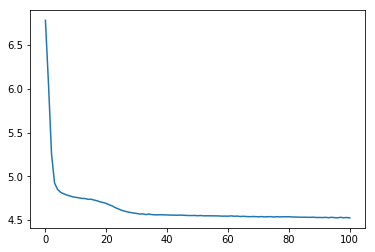

In [99]:
print len(NLL_list)
epoch_list = range(101)
print len(epoch_list)
plt.plot(epoch_list, NLL_list)
plt.show()